# 🖌 AI_Generated Art Detector 🔍
This notebook uses TensorFlow 2.18.0 and Tensor Hub to train a model to detect AI-generated artwork for companies testing the legitimacy of commissioned work.

##Problem
Wide availability of AI-powered models and online art has powered thieves to take others' work without permission to sell artwork generated by AI as their own work, endangering the financial stability of current artists as well as the future of unique human expression and online intercultural communication through art. Companies that want to support human artists need tools to help them recognize when AI-generated art has been marketed to or through them and help them make ethical business decisions.

##Data
The model was trained from this dataset available at Kaggle.com: https://www.kaggle.com/datasets/superpotato9/dalle-recognition-dataset/

##Evaluation
Target 75% accuracy of labeling art as human or AI-generated for this base layer application.
Goal to specialize with proprietary art to 90% accuracy

##Features
Unstructured data :. best to learn deep learning / transfer learning
No data file is provided for the image ids or classification and must be created
Images in .jpg format in two classes:
  Human-Generated - 3,781 (Reduced to 3,500)
  AI-Generated - 17,857 (Reduced to 3,500)


#Code to Train Model

In [ ]:
import tensorflow as tf
from tensorflow import keras as tfk
import pandas as pd
import zipfile
import os
import matplotlib.pyplot as plt
import datetime as dt
import kagglehub
import tensorflow_hub as hub
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


BATCH_SIZE = 32
IMG_SIZE = 224

####Function to Process Images

In [ ]:
#Function to process images
def process_img(img_path, augment=False):
  """
  Takes an image path and process the image into a 3-channel RGB tensor,
  resizes it to a square of s = IMG_SIZE,
  and returns the tensor
  """
  try:
        #Read in image file
        image = tf.io.read_file(img_path)
        #Decode image, allowing for different formats (JPEG, PNG, etc.)
        image = tf.image.decode_image(image, channels=3)

        #Ensure image has 3 channels (RGB)
        if image is None or image.shape[-1] != 3:
            print(f"Skipping image with incorrect shape: {img_path}")
            return None

        #Normalize color channel values
        image = tf.image.convert_image_dtype(image, tf.float32)
        #Resize image
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

        if augment:
            image = tf.expand_dims(image, axis=0)
            image = data_augmentation(image, training=True)
            image = tf.squeeze(image, axis=0)

        return image

  except tf.errors.InvalidArgumentError as e:
    print(f"Skipping corrupted image: {img_path} - {e}")
    return None #Return None for corrupted images

  except Exception as e:
    print(f"An unexpected error occurred while processing image {img_path}: {e}")
    return None

##Build Training Model

In [ ]:
#Wrapper to use TF Hub model inside Keras model
class HubFeatureExtractor(tfk.layers.Layer):
    """
    Defines custom layer to use TF Hub feature vector module inside Keras model
    """
    def __init__(self, hub_handle, **kwargs):
        super().__init__(**kwargs)
        self.hub_layer = hub.load(hub_handle)

    def call(self, inputs):
        # Assuming the hub module expects a single input.
        # Adjust if the module has a different signature.
        return self.hub_layer(inputs)


#Function to create model
def create_model():
    """
    Creates tensorflow model with EfficientNetV2 and data augmentation.
    Adam optimizer, sigmoid binary classification, and binary crossentropy loss
    Returns the model.

    Originally trained on MobileNetV2 for proof of concept, now using EfficientNetV2 to
    improve accuracy and reduce overfitting.
    """
    print("Building model with EfficientNetV2 and data augmentation")

    input_layer = tfk.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="input_image")

    # Apply data augmentation
    x = data_augmentation(input_layer)

    # Use EfficientNetV2 from TF Hub (much better than MobileNetV2)
    hub_handle = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2" # Corrected Hub handle
    # Use the custom HubFeatureExtractor layer
    feature_extractor = HubFeatureExtractor(hub_handle,
                                       trainable=True,  #frozen initially
                                       name="efficientnetv2_feature_extractor")

    x = feature_extractor(x)
    x = tfk.layers.Dropout(0.5)(x)
    output = tfk.layers.Dense(1, activation='sigmoid',
                              kernel_regularizer=tfk.regularizers.l2(0.01),
                              name="output")(x)

    model = tfk.Model(inputs=input_layer, outputs=output)

    #Makes trainable for fine-tuning after 5 epochs
    model.get_layer("efficientnetv2_feature_extractor").trainable = True
    model.compile(
        optimizer=tfk.optimizers.Adam(1e-5),
        loss=tfk.losses.BinaryCrossentropy(),
        metrics=['accuracy'])

    return model

#Code for Application

##UI

In [ ]:
#Main
"""
This application uses a TensorFlow model trained using the the EfficientNetV2
feature extractor from TensorFlow Keras to recognize features of AI-generated
art and make predictions about whether the image is AI-generated or not.

Users can upload individual images or zip file of multiple images to run
predictions and receive a csv file of the predictions and confidence levels
and can display images with the predictions and confidence levels.
"""

#Imports
import tensorflow as tf
from tensorflow import keras as tfk
import pandas as pd
import zipfile
import os
import matplotlib.pyplot as plt
import datetime as dt
import kagglehub
import tensorflow_hub as hub
import numpy as np
from google.colab import files


#Constants
IMG_SIZE = 224
BATCH_SIZE = 32

##Load Model

In [ ]:
def load_model(model_path):
  """
  Loads model from path as a regular Keras layer
  """
  print(f"Loading saved model from: {model_path}")
  # Pass the custom object to load_model
  model = tf.keras.models.load_model(model_path, custom_objects={"KerasLayer": hub.KerasLayer, "HubFeatureExtractor": HubFeatureExtractor})
  return model

In [ ]:
print("Enter path of downloaded model.")
#model_path = "C:\Users\Chelsea\Desktop\VAIAD_model.h5"
model_path = input()
loaded_model = load_model(model_path)

Loading saved model from: /content/drive/MyDrive/AI_Art_Detector/models/balanced_model.h5


##Upload Image(s) to Test

In [ ]:
def upload_images_to_test():
  """
  Invites user to upload image(s) to test if AI-generated
  """
  print("Would you like to test one image or many?")
  print("1. One image")
  print("2. Many images (as a zip file)")

  image_paths = []

  if input() == "1":
    #Upload one image
    uploaded = files.upload()
    for fn in uploaded.keys():
      image_paths.append(fn)
  else:
    #Upload many images
    print("Upload zip file of images")
    uploaded = files.upload()
    image_paths = get_filename_list(uploaded)

  #Confirm upload
  for fn in uploaded.keys():
    print('User uploaded file "{name}" to /contents'.format(name=fn))

  return uploaded,image_paths

In [ ]:
#Function to extract files from zip

def get_filename_list(uploaded):
    """
    Takes uploaded files and returns a list of file paths
    """
    image_paths = []
    for fn in uploaded.keys():
        # Extract zip file in current directory
        with zipfile.ZipFile(fn, "r") as zip_ref:
            zip_ref.extractall()
            extracted_names = zip_ref.namelist()

        # Iterate over all extracted files (full paths relative to cwd)
        for name in extracted_names:
            # Normalize path
            filepath = os.path.normpath(name)

            # Check if it's a file and has image extension
            if os.path.isfile(filepath) and filepath.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(filepath)

    return image_paths

###Process Images into Tensors

###Get Filepath(s)

In [ ]:
#Function definition
def process_img(img_path):
  """
  Takes an image path and process the image into a 3-channel RGB tensor,
  resizes it to a square of s = IMG_SIZE,
  and returns the tensor
  """
  try:
    #Read in image file
    image = tf.io.read_file(img_path)

    #Decode image, allowing for different formats (JPEG, PNG, etc.)
    image = tf.image.decode_image(image, channels=3)

    # Ensure image has 3 channels (RGB) and is not None after decoding
    if image is None or image.shape[-1] != 3:
        print(f"Skipping image with incorrect number of channels or invalid format: {img_path}")
        return None # Return None for invalid images

    #Normalize color channel values
    image = tf.image.convert_image_dtype(image, tf.float32)

    #Resize image
    image = tf.image.resize(image, size=[IMG_SIZE,IMG_SIZE])

    return image

  except tf.errors.InvalidArgumentError as e:
    print(f"Skipping corrupted or invalid image: {img_path} - {e}")
    return None #Return None for corrupted or invalid images

  except Exception as e:
    print(f"An unexpected error occurred while processing image {img_path}: {e}")
    return None

###Unbatch Uploaded Images

In [ ]:
#Function to unbatch uploaded images
def unbatch_uploads(uploaded_data):
  unbatched_images = []

  for image in uploaded_data.unbatch().as_numpy_iterator():
    unbatched_images.append(image)

  return unbatched_images

###Show Images Predicted as AI-Generated

In [ ]:
#Function to show images predicted as AI-generated
def show_images_predicted_as_AI(predictions, image_paths, upload_data):
    unbatched_images = unbatch_uploads(upload_data)

    #Get image names
    image_names = []
    for image_path in image_paths:
      image_names.append(image_path.split("/")[-1])

    #Remove Ticks
    plt.xticks([])
    plt.yticks([])

    #Calculate confidence
    confidence = [0] * len(predictions)

    for i in range(len(predictions)):
      confidence[i] = (1 - abs(predictions[i] - 0.5)) * 100

    #Get predction label
    predicted_label = [0] * len(predictions)
    for i in range(len(predictions)):
      if predictions[i] <= 0.5:
        predicted_label[i] = "AI"
      else:
        predicted_label[i] = "Human"

    #Show image for AI-generated predictions
    for i in range(len(predictions)):
      if predictions[i] <= 0.5:
        plt.imshow(unbatched_images[i])
        # Ensure image_names, predicted_label, and confidence are indexed correctly
        plt.title("Image Name: {} | Predicted: {} | Confidence: {:.2f}%".format(image_names[i], predicted_label[i], confidence[i].item())) # Use .item() to get the scalar value
        plt.show()

Welcome to the Volshebniki, Inc. AI-Generated Art Detector



Would you like to test an image? Y/N
y
Would you like to test one image or many?
1. One image
2. Many images (as a zip file)
1


Saving MortimusRex.jpg to MortimusRex.jpg
User uploaded file "MortimusRex.jpg" to /contents
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predictions saved to /content/drive/MyDrive/AI_Art_Detector/predictions
Would you like to see images predicted to be AI-generated? Y/N

y
Would you like to test another image? Y/N
y
Would you like to test one image or many?
1. One image
2. Many images (as a zip file)
2
Upload zip file of images


Saving app_demo_images.zip to app_demo_images.zip
User uploaded file "app_demo_images.zip" to /contents
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predictions saved to /content/drive/MyDrive/AI_Art_Detector/predictions
Would you like to see images predicted to be AI-generated? Y/N

y


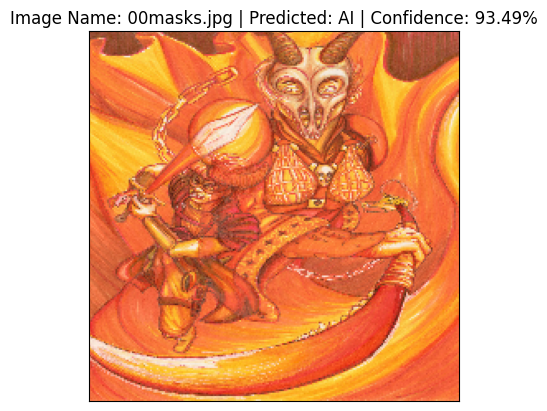

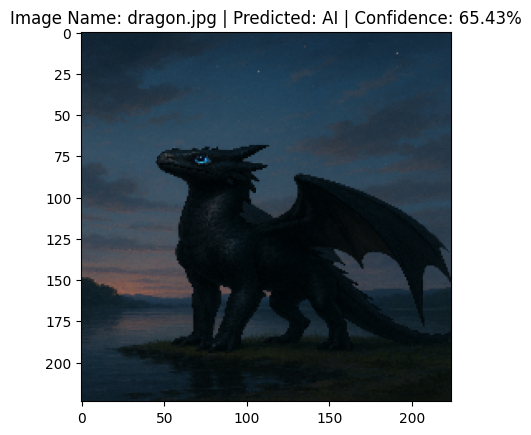

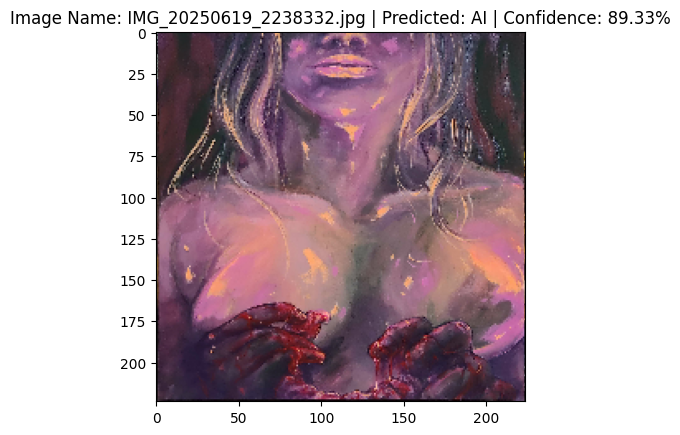

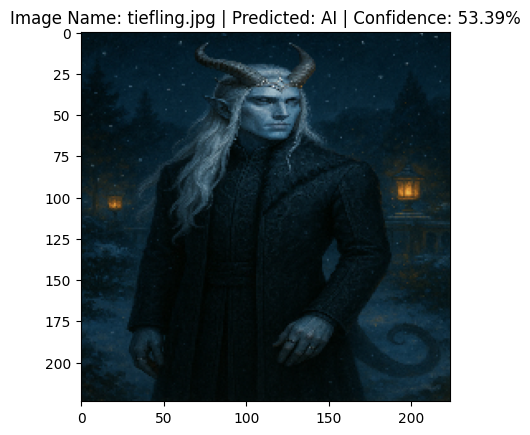

Would you like to test another image? Y/N
y
Would you like to test one image or many?
1. One image
2. Many images (as a zip file)
1


Saving 00masks.jpg to 00masks (1).jpg
User uploaded file "00masks (1).jpg" to /contents
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predictions saved to /content/drive/MyDrive/AI_Art_Detector/predictions
Would you like to see images predicted to be AI-generated? Y/N

y


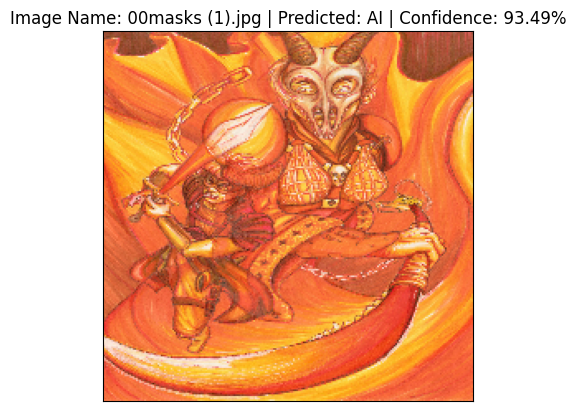

Would you like to test another image? Y/N
n
Thank you for using the Volshebniki, Inc. AI-Generated Art Detector


In [ ]:
#Main continued

#UI Header
print("Welcome to the Volshebniki, Inc. AI-Generated Art Detector")
print("\n\n")
run_test = input("Would you like to test an image? Y/N\n")

while run_test.upper() == "Y": #Using .upper() to handle both 'y' and 'Y'
  #Upload images to test
  uploaded, image_paths = upload_images_to_test()

  #Process uploaded images
  processed_images = []
  for image_path in image_paths:
      processed_img = process_img(image_path)
      if processed_img is not None:
          processed_images.append(processed_img)

  #Create batches of processed uploads
  if processed_images:
      processed_upload_data = tf.data.Dataset.from_tensor_slices(processed_images).batch(BATCH_SIZE)
  else:
      print("No valid images processed from the upload.")
      processed_upload_data = None


  if processed_upload_data:
      #Make predictions on test data using loaded full model
      test_predictions = loaded_model.predict(processed_upload_data, verbose=1)

      #Add columns to predictions with image name, label, and confidence
      image_names = []
      for image_path in image_paths:
        image_names.append(image_path.split("/")[-1])

      prediction_rounded = [0] * len(test_predictions)
      for i in range(len(test_predictions)):
        if test_predictions[i] >= 0.5:
          prediction_rounded[i] = 1
        else:
          prediction_rounded[i] = 0

      confidence = [0] * len(test_predictions)

      for i in range(len(test_predictions)):
        confidence[i] = (1 - abs(test_predictions[i] - prediction_rounded[i])) * 100

      test_predictions_df = pd.DataFrame({"Image Name": image_names, "Prediction": prediction_rounded, "Confidence": confidence})

      #Option: Save Predictions
      print("Would you like to save the predictions? Y/N\n")
      save_predictions = input()
      if save_predictions.upper() == "Y":
          #Ask for path to save file
          print("Enter the path to save the predictions file:")
          #path = "/content/drive/MyDrive/AI_Art_Detector/predictions"
          path = input()
          #Save predictions dataframe to csv file with timestamp
          timestamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
          #Create directory if it doesn't exist
          os.makedirs(path, exist_ok=True)
          suffix = "test_predictions"
          filename = f"{path}/{suffix}_{timestamp}.csv"
          test_predictions_df.to_csv(filename, index=False)
          print(f"Predictions saved to {filename}")

      #Option: Show images predicted to be AI-generated
      print("Would you like to see images predicted to be AI-generated? Y/N\n")
      show_AI = input()
      if show_AI.upper() == "Y": # Using .upper()
          #Pass images and predictions to function
          show_images_predicted_as_AI(test_predictions, image_paths,processed_upload_data)
  else:
      print("Could not create data batches for prediction.")

  #Option: Test more images
  run_test = input("Would you like to test another image? Y/N\n")

print("Thank you for using the Volshebniki, Inc. AI-Generated Art Detector")

#exit()